In [2]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
pd.set_option("display.max_columns", 120)
print("pandas", pd.__version__)


pandas 2.3.1


In [3]:
from pathlib import Path

def detect_csvs(project_root=Path("..")):
    cand_roots = [project_root, project_root/"data", Path("."), Path("..")]
    names = {
        "tran": "dcpc_2024_tranlevel_public.csv",
        "day" : "dcpc_2024_daylevel_public.csv",
        "ind" : "dcpc_2024_indlevel_public.csv",
    }
    paths = {}
    for k, fn in names.items():
        found = None
        for r in cand_roots:
            p = (r/fn)
            if p.exists():
                found = p.resolve(); break
        if found is None:
            p = project_root/"data"/fn
            if p.exists(): found = p.resolve()
        paths[k] = found
    return paths

paths = detect_csvs(Path(".."))
pprint(paths)
assert paths["tran"] is not None, "TRAN csv not found; put it under ../data/ or project root."
tran_path = paths["tran"]
tran_path


{'day': WindowsPath('C:/Users/Kaiyan Zhang/Desktop/dcpc-friction-dml/data/dcpc_2024_daylevel_public.csv'),
 'ind': WindowsPath('C:/Users/Kaiyan Zhang/Desktop/dcpc-friction-dml/data/dcpc_2024_indlevel_public.csv'),
 'tran': WindowsPath('C:/Users/Kaiyan Zhang/Desktop/dcpc-friction-dml/data/dcpc_2024_tranlevel_public.csv')}


WindowsPath('C:/Users/Kaiyan Zhang/Desktop/dcpc-friction-dml/data/dcpc_2024_tranlevel_public.csv')

In [4]:
tran = pd.read_csv(tran_path, low_memory=False)

def pick(df, opts):
    for c in opts:
        if c in df.columns: return c
    return None

ID_COLS  = ["_id","id","person_id","PID"]
DATE_COL = ["_date","date"]
AMT_COL  = ["_amount","amount","amnt"]

id_col   = pick(tran, ID_COLS)
date_col = pick(tran, DATE_COL)
amt_col  = pick(tran, AMT_COL)

print("Using columns:", {"id":id_col, "date":date_col, "amount":amt_col})

tran[id_col]   = pd.to_numeric(tran[id_col], errors="coerce")
tran[date_col] = pd.to_datetime(tran[date_col], errors="coerce")
tran[amt_col]  = pd.to_numeric(tran[amt_col], errors="coerce")

print("Shape:", tran.shape)
tran.head(3)


Using columns: {'id': 'id', 'date': 'date', 'amount': 'amnt'}
Shape: (32267, 67)


,id,old_diary_day,date,tran,tran_report,amnt_orig,payamnt_erramnt,pi,amnt,amnt_flag,merch,cc_surcharge,q101ee,device,time,in_person,diary_day,mobile_method,authorization_method,pay010,pay011,pay082,p2p_type,p2p_business,ccbaldue,enough_cash,accept_cash,accept_card,dc_rewards,used_rewards_cc,used_revolve_cc,cc_discount,prepaid_logo,mobile_funding,mobile_app,monord_source,monord_date,why_multipi,billautom,bill,payee,multipi_breakdown,discount,tran_min,paylocaltime,payment,module,start_date,nonpaymenttran,cashdepmethod,cashdeptime,cashdepaccount,chkdepfunds,cashgetlocation,cashgetsource,cashgetfee,cashgettime,chktransferaccount,chktransferfee,chktransferwhenrec,chktransferinstitution,q211paymeth,uncommon_pi_type,prepaidloadmethod,prepaidloadlocation,prepaidloadfee,transaction_reported_on_day
0,103858,1,2024-09-29,1,1.0,50.0,NaN,2.0,50.0,NaN,17.0,NaN,NaN,7.0,12:00 AM,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0,NaN,NaN,NaN,00:00,1,bills_purchases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,104674,1,2024-09-29,1,1.0,8.0,NaN,11.0,8.0,NaN,15.0,NaN,NaN,1.0,12:00 AM,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,00:00,1,bills_purchases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,101352,1,2024-09-29,1,1.0,5.0,NaN,4.0,5.0,NaN,1.0,NaN,2.0,7.0,12:00 AM,1.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,NaN,0.0,0.0,00:00,1,bills_purchases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
# ==== STRICT 版：仅由 PI 判定低/高摩擦，并丢弃其他/缺失 ====
# 保留真实支付
is_payment = (tran.get("payment", 1) == 1) & (tran.get("nonpaymenttran").isna())
tx = tran[is_payment].copy()

# 强制数值化 pi
if "pi" not in tx.columns:
    raise ValueError("严格规则需要 'pi' 列，请确认 TRAN 表含有 pi。")
tx["pi"] = pd.to_numeric(tx["pi"], errors="coerce")

# 规则定义
STRICT_LOW  = {3, 4, 6, 7}      # 低摩擦：信用/借记/ACH/OBBP（全电子）
STRICT_HIGH = {1, 2, 8}         # 高摩擦：现金/支票/汇票
STRICT_KEEP = STRICT_LOW | STRICT_HIGH
STRICT_DROP = {0, 5, 10, 11, 12, 13, 14}  # 多方式/PayPal残留/转账/手机残留/其它/代扣 等都丢弃

# 统计丢弃量（含 NaN）
before = len(tx)
tx_strict = tx[tx["pi"].isin(STRICT_KEEP)].copy()
dropped = before - len(tx_strict) + tx_strict["pi"].isna().sum()  # 只是报告用
print(f"[STRICT] Before: {before:,}  After: {len(tx_strict):,}  Dropped (incl. NaN & others): {before - len(tx_strict):,}")

# 构造低摩擦指示（仅基于 PI）
tx_strict["low_friction_txn"] = np.where(tx_strict["pi"].isin(STRICT_LOW), 1, 0).astype(int)

# 可选：查看分布
print("\n[STRICT] PI value counts kept:")
print(tx_strict["pi"].value_counts(dropna=False).sort_index())
print("\n[STRICT] low_friction_txn share:", round(tx_strict["low_friction_txn"].mean(), 4))

# 将后续流水线用的 DataFrame 命名为 tx（与后面代码保持一致）
tx = tx_strict


[STRICT] Before: 28,810  After: 26,136  Dropped (incl. NaN & others): 2,674

[STRICT] PI value counts kept:
pi
1.0    4082
2.0     829
3.0    9777
4.0    7768
6.0    1816
7.0    1821
8.0      43
Name: count, dtype: int64

[STRICT] low_friction_txn share: 0.8105


Cell 5 — 仅线下 in-person

In [6]:
tx["_inperson"] = pd.to_numeric(tx.get("in_person"), errors="coerce")
tx_ip = tx[tx["_inperson"] == 1].copy()
print("In-person transactions:", tx_ip.shape)


In-person transactions: (16704, 69)


Cell 6 — 聚合到 人×日（T、Y、weekday）

In [7]:
g = tx_ip.groupby([id_col, date_col], as_index=False)
day_ip = g.agg(
    day_total_amount=(amt_col, "sum"),
    n_tx=(amt_col, "size"),
    n_low_tx=("low_friction_txn", "sum"),
)
day_ip = day_ip.rename(columns={id_col:"_id", date_col:"_date"})
day_ip["T_share_low"] = (day_ip["n_low_tx"] / day_ip["n_tx"]).fillna(0.0)
day_ip["Y_log_amt"]   = np.log1p(day_ip["day_total_amount"])
day_ip["_weekday"]    = pd.to_datetime(day_ip["_date"]).dt.weekday

day_ip.head(3)


,_id,_date,day_total_amount,n_tx,n_low_tx,T_share_low,Y_log_amt,_weekday
0,100001,2024-10-13,50.00,1,0,0.0,3.931826,6
1,100001,2024-10-14,40.24,1,1,1.0,3.719409,0
2,100003,2024-10-27,18.00,1,0,0.0,2.944439,6


Cell 7 — Merch 篮子（Top-20 占比）

In [8]:
if "merch" in tx_ip.columns:
    vc = tx_ip["merch"].value_counts()
    # pick top-20 safely
    top_merch = vc.nlargest(20) if hasattr(vc, "nlargest") else vc.head(20)
    top_merch = list(top_merch.index)

    piv = (tx_ip.assign(one=1)
                 .query("merch in @top_merch")
                 .pivot_table(index=[id_col, date_col], columns="merch", values="one",
                              aggfunc="sum", fill_value=0))
    # make pivot index names match day_ip ('_id','_date') so merge with right_index=True works
    piv.index.names = ["_id", "_date"]
    piv = piv.div(piv.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
    piv.columns = [f"mshare_{int(c)}" for c in piv.columns]
    day_ip = day_ip.merge(piv, left_on=["_id","_date"], right_index=True, how="left").fillna(0.0)

X_cols = ["_weekday"] + [c for c in day_ip.columns if str(c).startswith("mshare_")]
print("#X columns:", len(X_cols))
day_ip.head(3)


#X columns: 21


,_id,_date,day_total_amount,n_tx,n_low_tx,T_share_low,Y_log_amt,_weekday,mshare_1,mshare_2,mshare_3,mshare_4,mshare_5,mshare_6,mshare_7,mshare_8,mshare_9,mshare_10,mshare_12,mshare_13,mshare_14,mshare_15,mshare_16,mshare_17,mshare_18,mshare_19,mshare_20,mshare_21
0,100001,2024-10-13,50.00,1,0,0.0,3.931826,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,100001,2024-10-14,40.24,1,1,1.0,3.719409,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,2024-10-27,18.00,1,0,0.0,2.944439,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# 修剪 T 保证重叠
day_ip["T_share_low_trim"] = day_ip["T_share_low"].clip(0.05, 0.95)

# 按日活跃人数做权重（后续 DML 用）
active = (day_ip.groupby("_date").agg(active_persons=("_id","nunique")).reset_index())
w_day  = (active["active_persons"] / active["active_persons"].mean()).clip(0.2, 2.0)
day_ip = day_ip.merge(active.assign(w_day=w_day), on="_date", how="left")

day_ip.shape, day_ip[["T_share_low","T_share_low_trim","Y_log_amt","w_day"]].describe()


((8247, 31),
        T_share_low  T_share_low_trim    Y_log_amt        w_day
 count  8247.000000       8247.000000  8247.000000  8247.000000
 mean      0.728217          0.706457     3.925927     1.169268
 std       0.398040          0.358903     1.315274     0.180862
 min       0.000000          0.050000    -0.235722     0.200000
 25%       0.500000          0.500000     3.044522     1.130108
 50%       1.000000          0.950000     3.931826     1.202862
 75%       1.000000          0.950000     4.745236     1.265915
 max       1.000000          0.950000    10.312128     1.396872)

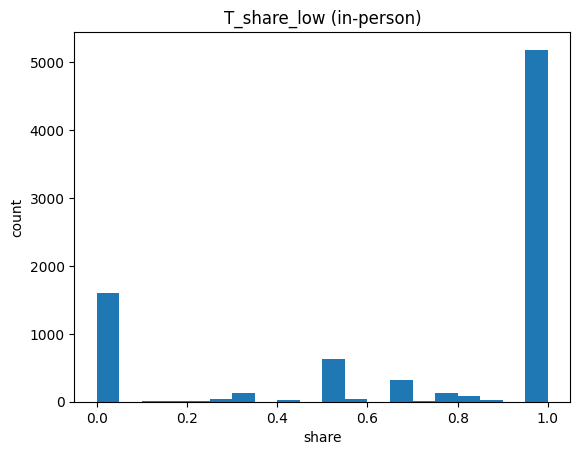

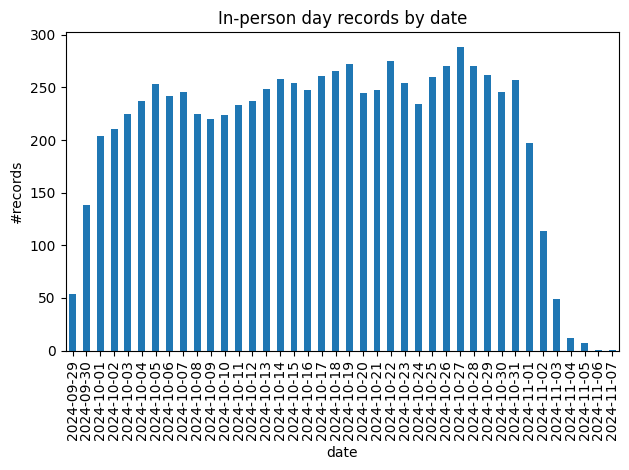

In [10]:
plt.figure()
plt.hist(day_ip["T_share_low"], bins=20)
plt.title("T_share_low (in-person)")
plt.xlabel("share"); plt.ylabel("count")
plt.show()

plt.figure()
day_ip["_date"].dt.date.value_counts().sort_index().plot(kind="bar")
plt.title("In-person day records by date")
plt.xlabel("date"); plt.ylabel("#records")
plt.tight_layout(); plt.show()


C:\Users\Kaiyan Zhang\AppData\Local\Temp\ipykernel_24328\2006158010.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(ordered_cats))


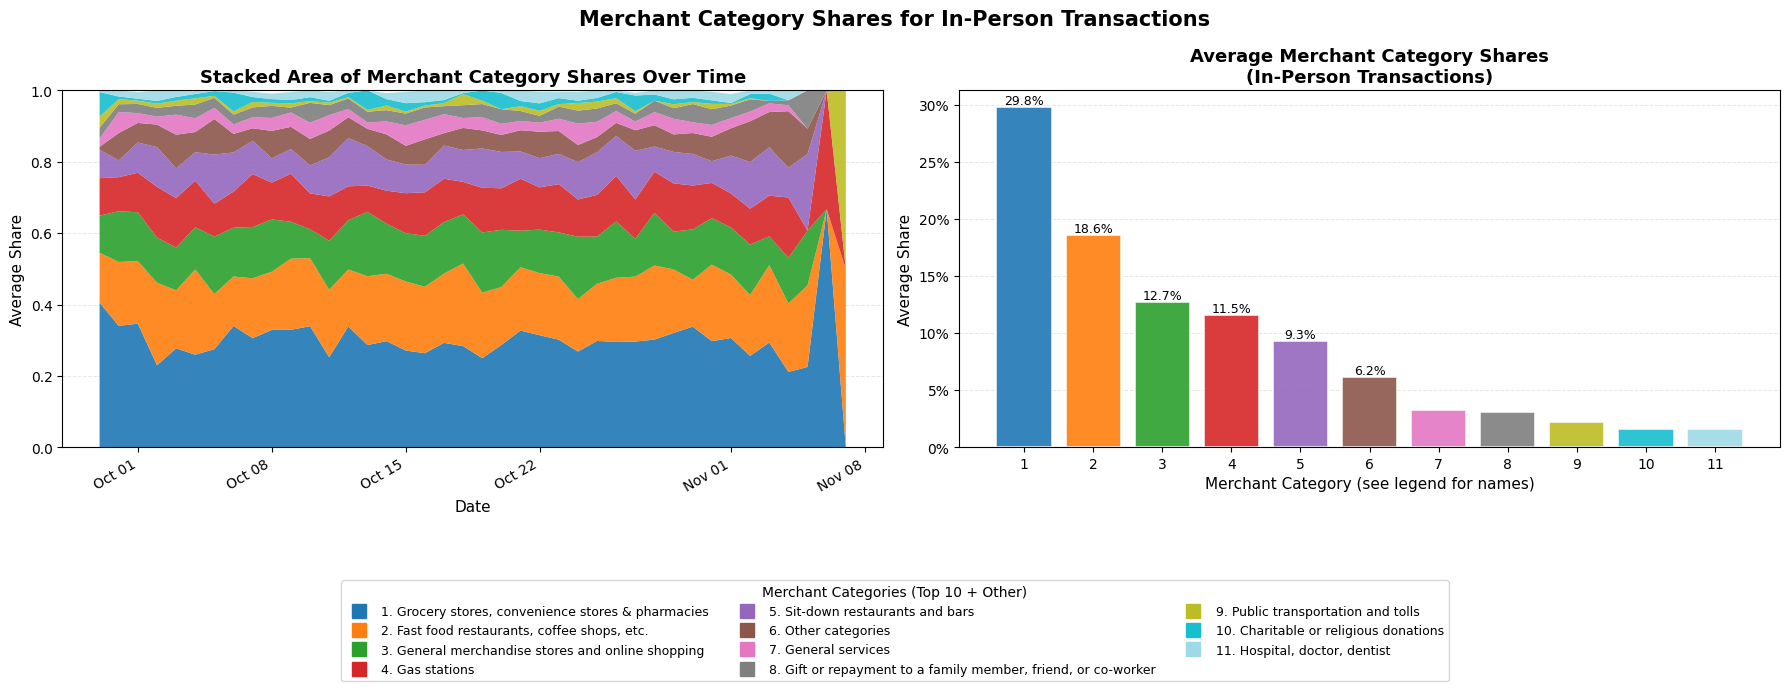

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

# 1. 按天计算各 merchant share 的日均值
mcols = [c for c in day_ip.columns if c.startswith("mshare_")]
daily_avg = (
    day_ip
    .groupby("_date")[mcols]
    .mean()
    .sort_index()
)

# 2. 改列名（和你之前一样）
daily_avg_renamed = daily_avg.rename(columns={
    'mshare_1': "Grocery stores, convenience stores & pharmacies",
    'mshare_2': "Gas stations",
    'mshare_3': "Sit-down restaurants and bars",
    'mshare_4': "Fast food restaurants, coffee shops, etc.",
    'mshare_5': "General merchandise stores and online shopping",
    'mshare_6': "General services",
    'mshare_7': "Arts, entertainment, recreation",
    'mshare_8': "Utilities not paid to the government",
    'mshare_9': "Taxis, airplanes, delivery",
    'mshare_10': "Telephone, internet, cable or satellite TV",
    'mshare_11': "Building contractors, plumbers, electricians, etc.",
    'mshare_12': "Professional services",
    'mshare_13': "Hotels, motels, RV parks, campsites",
    'mshare_14': "Rent for apartments, homes, or other buildings",
    'mshare_15': "Mortgage, credit card companies, banks, insurance",
    'mshare_16': "Gift or repayment to a family member, friend, or co-worker",
    'mshare_17': "Charitable or religious donations",
    'mshare_18': "Hospital, doctor, dentist",
    'mshare_19': "Government taxes or fees",
    'mshare_20': "Schools, colleges, childcare centers",
    'mshare_21': "Public transportation and tolls",
})

# 3. 先算整体平均 share，并取 Top-K，其余合成 "Other categories"
avg_shares_all = daily_avg_renamed.mean().sort_values(ascending=False)

TOP_K = 10
top_cats = avg_shares_all.index[:TOP_K]
other_cats = avg_shares_all.index[TOP_K:]

daily_top = daily_avg_renamed[top_cats].copy()
if len(other_cats) > 0:
    daily_top["Other categories"] = daily_avg_renamed[other_cats].sum(axis=1)

# 再在 Top-K+Other 内部按 share 排一次序，方便两个子图统一顺序
avg_shares = daily_top.mean().sort_values(ascending=False)
ordered_cats = avg_shares.index.tolist()
daily_top = daily_top[ordered_cats]

# 4. 颜色：对每个类别固定一套颜色，两个子图共用
cmap = cm.get_cmap("tab20", len(ordered_cats))
color_dict = {cat: cmap(i) for i, cat in enumerate(ordered_cats)}

# 5. 画图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("Merchant Category Shares for In-Person Transactions", fontsize=15, fontweight="bold")

# ---- 左图：stacked area (Top-K + Other) ----
# 用 stackplot，顺序和颜色都用 ordered_cats
ax1.stackplot(
    daily_top.index,
    [daily_top[c].values for c in ordered_cats],
    labels=ordered_cats,
    colors=[color_dict[c] for c in ordered_cats],
    alpha=0.9
)

ax1.set_ylim(0, 1)
ax1.set_ylabel("Average Share", fontsize=11)
ax1.set_xlabel("Date", fontsize=11)
ax1.set_title("Stacked Area of Merchant Category Shares Over Time", fontsize=13, fontweight="bold")
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax1.set_axisbelow(True)

# 日期格式好看一点
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax1.get_xticklabels(), rotation=30, ha='right')

# ---- 右图：平均 share 的柱状图 ----
bars = ax2.bar(
    range(len(ordered_cats)),
    avg_shares.values,
    color=[color_dict[c] for c in ordered_cats],
    edgecolor='white',
    linewidth=1.2,
    alpha=0.9
)

ax2.set_title("Average Merchant Category Shares\n(In-Person Transactions)", fontsize=13, fontweight="bold")
ax2.set_ylabel("Average Share", fontsize=11)
ax2.set_xticks(range(len(ordered_cats)))
# 只在 x 轴写简短标签，完整名字在 legend 里看
short_labels = [f"{i+1}" for i in range(len(ordered_cats))]
ax2.set_xticklabels(short_labels)
ax2.set_xlabel("Merchant Category (see legend for names)", fontsize=11)

# y 轴用百分比
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax2.set_axisbelow(True)

# 在 bar 顶部标注数值（只标 >5% 的）
for bar, val in zip(bars, avg_shares.values):
    if val > 0.05:
        ax2.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"{val:.1%}",
            ha='center', va='bottom', fontsize=9
        )

# ---- 共用 legend：完整类别名称 + 对应颜色 ----
legend_handles = [
    plt.Line2D([0], [0], marker='s', linestyle='',
               color=color_dict[c], markersize=10)
    for c in ordered_cats
]

fig.legend(
    legend_handles,
    [f"{i+1}. {name}" for i, name in enumerate(ordered_cats)],
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.15),
    fontsize=9,
    frameon=True,
    title="Merchant Categories (Top 10 + Other)",
    title_fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # 给 legend 留空间
plt.show()

In [ ]:
out = Path("..")/"outputs"/"day_inperson_ready.csv"
day_ip.to_csv(out, index=False)
print("Saved:", out)


Saved: ..\outputs\day_inperson_ready.csv


=== Counts table ===


pi_label,cash,check,money order,credit,debit,ACH,OBBP
friction_tier,,,,,,,
0,4082,829,43,0,0,0,0
2,0,0,0,9777,7768,1816,1821



=== Shares table ===


pi_label,cash,check,money order,credit,debit,ACH,OBBP
friction_tier,,,,,,,
0,0.824,0.167,0.009,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.462,0.367,0.086,0.086


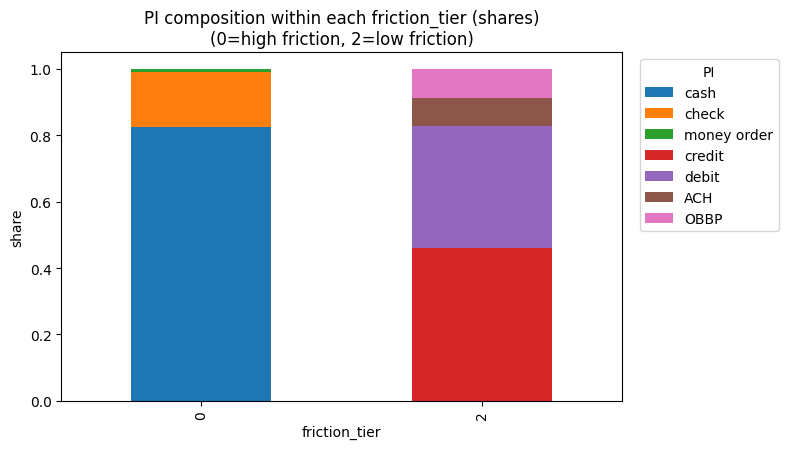

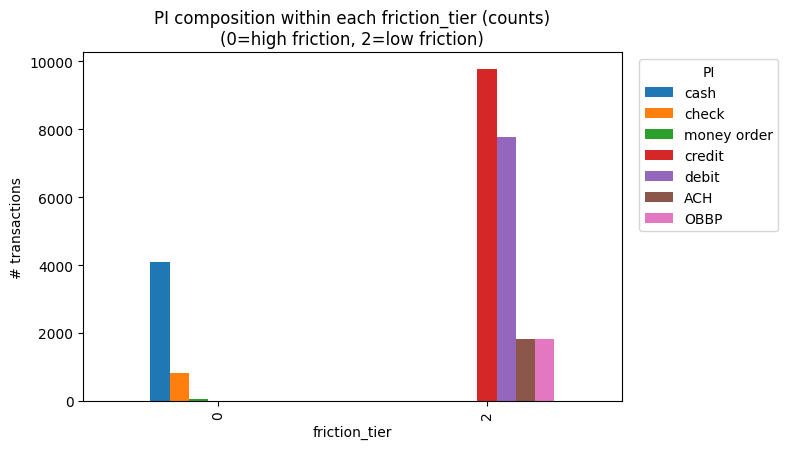


Records used: 26136
Tier counts: {0: 4954, 2: 21182}


In [ ]:

assert tran_path.exists(), f"TRAN csv not found: {TRAN_PATH}"

# ---- switches ----
IN_PERSON_ONLY = False  # True → 只看 in_person==1 的线下样本
LOW  = {3,4,6,7}      # credit/debit/ACH/OBBP
HIGH = {1,2,8}        # cash/check/money order
KEEP = LOW | HIGH

pi_labels = {
    1:"cash", 2:"check", 8:"money order",
    3:"credit", 4:"debit", 6:"ACH", 7:"OBBP"
}
# 为了图例排序更友好，按下面顺序显示
plot_order = ["cash","check","money order","credit","debit","ACH","OBBP"]

# ---- load & basic filter ----
df = pd.read_csv(TRAN_PATH, low_memory=False)

def pick(df, opts):
    for c in opts:
        if c in df.columns: return c
    return None

id_col   = pick(df, ["_id","id","person_id"])
date_col = pick(df, ["_date","date"])
amt_col  = pick(df, ["_amount","amnt","amount"])

# 仅真实支付
is_payment = (df.get("payment", 1) == 1) & (df.get("nonpaymenttran").isna())
df = df[is_payment].copy()

# 只保留 pi 在 KEEP 的记录；将其余/缺失全部丢弃（最保守）
df["pi"] = pd.to_numeric(df.get("pi"), errors="coerce")
df = df[df["pi"].isin(KEEP)].copy()

# 可选：只看线下
if IN_PERSON_ONLY and "in_person" in df.columns:
    df = df[pd.to_numeric(df["in_person"], errors="coerce") == 1].copy()

# ---- friction_tier（严格只两档：0/2）----
df["friction_tier"] = np.where(df["pi"].isin(LOW), 2,
                         np.where(df["pi"].isin(HIGH), 0, np.nan))
df = df.dropna(subset=["friction_tier"]).copy()
df["friction_tier"] = df["friction_tier"].astype(int)

# 友好标签列
df["pi_label"] = df["pi"].map(pi_labels).fillna(df["pi"].astype(str))

# ---- pivot: counts & shares ----
counts = (df
          .groupby(["friction_tier","pi_label"])
          .size()
          .unstack(fill_value=0)
          .reindex(columns=[c for c in plot_order if c in df["pi_label"].unique()]))

shares = counts.div(counts.sum(axis=1), axis=0)

print("=== Counts table ===")
display(counts)

print("\n=== Shares table ===")
display(shares.round(3))

# ---- plot: shares (stacked) ----
plt.figure(figsize=(8,4.6))
shares.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("PI composition within each friction_tier (shares)\n(0=high friction, 2=low friction)")
plt.xlabel("friction_tier"); plt.ylabel("share")
plt.legend(title="PI", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

# ---- plot: counts (grouped) ----
plt.figure(figsize=(8,4.6))
counts.plot(kind="bar", stacked=False, ax=plt.gca())
plt.title("PI composition within each friction_tier (counts)\n(0=high friction, 2=low friction)")
plt.xlabel("friction_tier"); plt.ylabel("# transactions")
plt.legend(title="PI", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

# ---- sanity prints ----
print("\nRecords used:", len(df))
print("Tier counts:", df["friction_tier"].value_counts().sort_index().to_dict())
